# **Analisis dan Prediksi Kadar PM2.5 Harian Jakarta dengan Model ARIMA**

Proyek ini bertujuan untuk memprediksi konsentrasi PM2.5 di Jakarta menggunakan pendekatan time series. PM2.5 merupakan salah satu indikator kualitas udara yang penting karena berdampak pada kesehatan pernapasan manusia.

# **1.Import Library dan Load Dataset**

Pada tahap ini, kita mengimpor library yang diperlukan dan memuat dataset kualitas udara dari stasiun ISPU DKI1 (Bunderan HI). Dataset berisi data pengukuran harian PM2.5, yang merupakan polutan utama dan berdampak buruk bagi kesehatan manusia.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('ispu_dki1.csv')

print("Tanggal paling awal:", df['tanggal'].min())
print("Tanggal paling akhir:", df['tanggal'].max())


Tanggal paling awal: 2010-01-01
Tanggal paling akhir: 2025-02-28


# **2.PreProcessing & Filter Data 2023-2025**

Pada tahap ini dilakukan:
- Konversi kolom tanggal menjadi tipe datetime
- Seleksi kolom `tanggal` dan `pm25` saja
- Menghapus nilai kosong
- Menjadikan kolom tanggal sebagai index
- Resampling ke frekuensi harian (daily)
- Memfilter data hanya dari **1 Januari 2023 hingga 28 Februari 2025** untuk fokus pemodelan.


In [11]:
print("Jumlah baris dan kolom:", df.shape)
print("\nInformasi dataset:")
print(df.info())

print("\nStatistik deskriptif:")
print(df.describe())

print("\nJumlah nilai kosong per kolom:")
print(df.isnull().sum())

print("\nJumlah duplikasi:")
print(df.duplicated().sum())


Jumlah baris dan kolom: (5173, 11)

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5173 entries, 0 to 5172
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   5173 non-null   datetime64[ns]
 1   stasiun   5173 non-null   object        
 2   pm25      1146 non-null   float64       
 3   pm10      4957 non-null   float64       
 4   so2       4985 non-null   float64       
 5   co        5005 non-null   float64       
 6   o3        4964 non-null   float64       
 7   no2       4974 non-null   float64       
 8   max       5160 non-null   float64       
 9   critical  5059 non-null   object        
 10  categori  5173 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 444.7+ KB
None

Statistik deskriptif:
                             tanggal         pm25         pm10          so2  \
count                           5173  1146.000000  4957.0000

In [12]:
df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')

df_pm25 = df[['tanggal', 'pm25']].copy()
df_pm25.dropna(inplace=True)

df_pm25.set_index('tanggal', inplace=True)
df_pm25 = df_pm25.resample('D').mean()

data_pm25 = df_pm25.loc['2023-01-01':'2025-02-28']
print("Jumlah data:", len(data_pm25))

Jumlah data: 790


# **3. Feature Engineering**

Untuk memperkaya data time series, ditambahkan fitur tambahan:
- `dayofweek` = hari dalam minggu (0=Senin, 6=Minggu)
- `month` = bulan (1–12)
- `is_weekend` = apakah hari itu akhir pekan (Sabtu/Minggu)

Fitur-fitur ini berguna untuk mengidentifikasi pola musiman atau tren mingguan/bulanan dalam kadar PM2.5.

In [13]:
data_fe = data_pm25.copy()
data_fe['dayofweek'] = data_fe.index.dayofweek     
data_fe['month'] = data_fe.index.month
data_fe['is_weekend'] = data_fe['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

print(data_fe.head())


            pm25  dayofweek  month  is_weekend
tanggal                                       
2023-01-01  55.0          6      1           1
2023-01-02  43.0          0      1           0
2023-01-03  35.0          1      1           0
2023-01-04  47.0          2      1           0
2023-01-05  50.0          3      1           0


# **4. Visualisasi PM2.5 Musiman**

Tahap ini bertujuan untuk melihat tren polusi berdasarkan:
- Hari dalam seminggu (apakah ada tren PM2.5 meningkat di akhir pekan?)
- Bulan dalam setahun (apakah ada tren musiman seperti musim kemarau atau penghujan?)

Visualisasi menggunakan diagram batang agar pola musiman terlihat jelas.

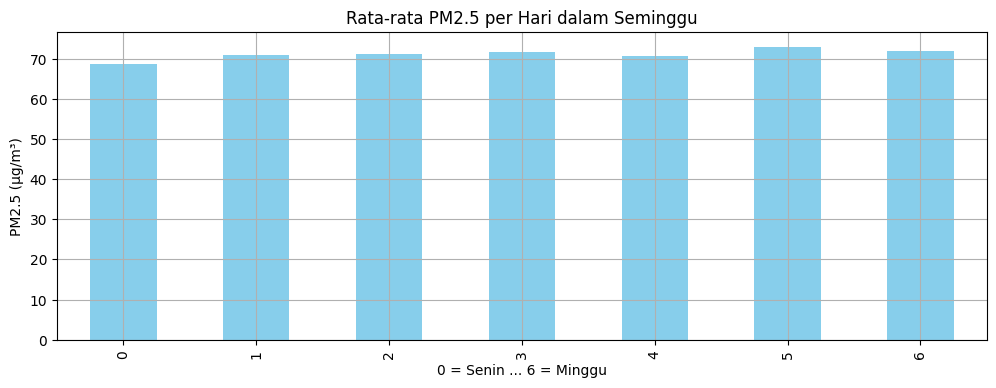

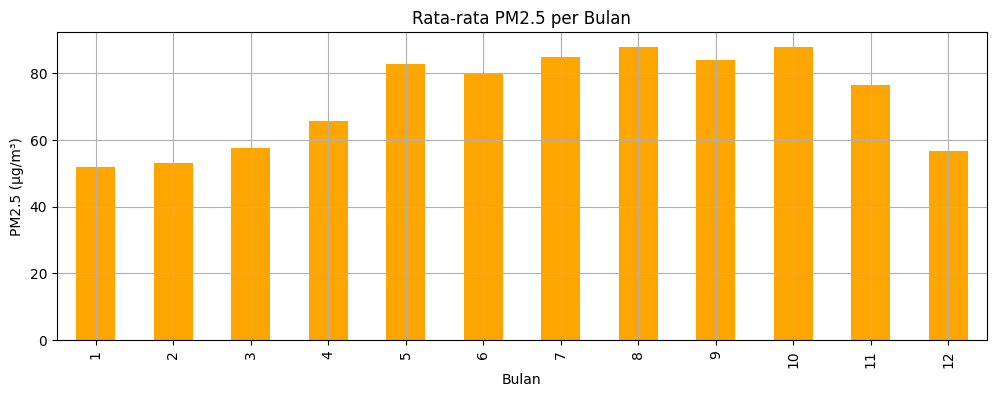

In [14]:
plt.figure(figsize=(12,4))
data_fe.groupby('dayofweek')['pm25'].mean().plot(kind='bar', color='skyblue')
plt.title('Rata-rata PM2.5 per Hari dalam Seminggu')
plt.xlabel('0 = Senin ... 6 = Minggu')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
data_fe.groupby('month')['pm25'].mean().plot(kind='bar', color='orange')
plt.title('Rata-rata PM2.5 per Bulan')
plt.xlabel('Bulan')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()


# **5.Split Data Train dan Test**

Data `PM2.5` dibagi menjadi dua bagian:
- **Train (80%)**: digunakan untuk membangun model
- **Test (20%)**: digunakan untuk mengevaluasi performa model

Pembagian ini umum dilakukan dalam modeling machine learning maupun time series untuk menghindari overfitting.


In [15]:
pm25_series = data_fe['pm25']

train_size = int(len(pm25_series) * 0.8)
train = pm25_series[:train_size]
test = pm25_series[train_size:]

print("Train:", len(train), "Test:", len(test))


Train: 632 Test: 158


# **6.Latih Model**

Model yang digunakan adalah **ARIMA (AutoRegressive Integrated Moving Average)** dengan parameter (5,1,0).

Model ARIMA dipilih karena:
- Cocok untuk data time series tanpa fitur eksternal
- Mampu menangkap pola autoregresif, diferensiasi tren, dan noise

Model dilatih (fit) menggunakan data train.

In [16]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                  632
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2463.810
Date:                Tue, 08 Jul 2025   AIC                           4939.619
Time:                        10:26:24   BIC                           4966.303
Sample:                    01-01-2023   HQIC                          4949.983
                         - 09-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4428      0.038    -11.539      0.000      -0.518      -0.368
ar.L2         -0.3144      0.041     -7.618      0.000      -0.395      -0.234
ar.L3         -0.2371      0.044     -5.436      0.0

# **7. Prediksi Test Set dan Evaluasi Performa**

Setelah model dilatih, dilakukan prediksi sepanjang data test.

Evaluasi dilakukan dengan dua metrik:
- **MAE (Mean Absolute Error)**: rata-rata selisih absolut antara nilai aktual dan prediksi
- **RMSE (Root Mean Squared Error)**: mengukur deviasi prediksi terhadap nilai aktual dengan penalti lebih besar untuk kesalahan besar

Visualisasi hasil prediksi vs aktual juga disertakan agar terlihat performanya.


In [17]:
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

df_eval = pd.DataFrame({
    'actual': test,
    'predicted': forecast
}).dropna()

mae = mean_absolute_error(df_eval['actual'], df_eval['predicted'])
rmse = np.sqrt(mean_squared_error(df_eval['actual'], df_eval['predicted']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 28.31
RMSE: 33.36


# **8.Visualisasi Hasil Prediksi vs Aktual**

Grafik di bawah ini menunjukkan perbandingan antara nilai **PM2.5 aktual** dan **hasil prediksi** dari model ARIMA pada data uji (test set). Visualisasi ini sangat penting untuk memahami seberapa baik model dalam menangkap pola musiman, tren, dan fluktuasi dari data yang sebenarnya.

- **Garis biru** mewakili data aktual dari tahun 2024–2025.
- **Garis merah** menunjukkan hasil prediksi model ARIMA.

Jika garis prediksi mengikuti pola garis aktual dengan baik, berarti model cukup akurat dalam melakukan peramalan kualitas udara (PM2.5).

Grafik ini juga membantu mendeteksi:
- Overfitting (prediksi terlalu mengikuti noise)
- Underfitting (prediksi terlalu datar dan tidak mengikuti pola)

Visualisasi ini melengkapi metrik evaluasi kuantitatif (MAE dan RMSE) dengan pemahaman visual yang lebih intuitif.


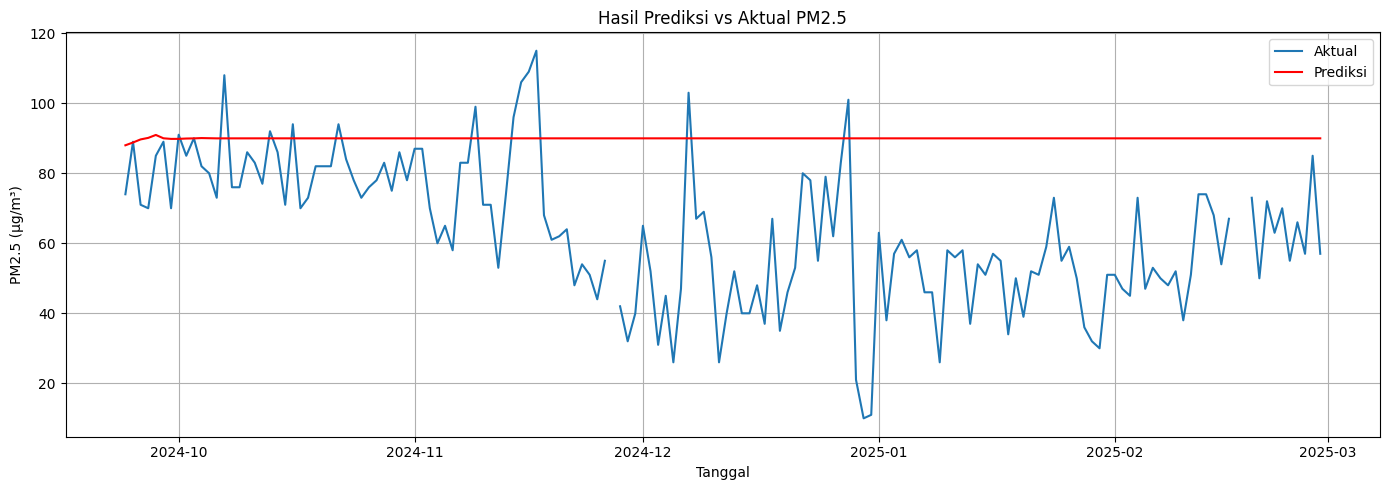

In [18]:
plt.figure(figsize=(14,5))
plt.plot(test, label='Aktual')
plt.plot(forecast, label='Prediksi', color='red')
plt.title('Hasil Prediksi vs Aktual PM2.5')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **9. Prediksi 30 Hari Kedepan**

Model digunakan untuk memprediksi nilai PM2.5 untuk **30 hari setelah data terakhir (Februari 2025)**.

Output ditampilkan dalam bentuk tabel berisi:
- Tanggal prediksi
- Nilai prediksi PM2.5

Hasil ini bisa berguna untuk estimasi kondisi udara di masa depan untuk mendukung kebijakan publik atau peringatan dini.


In [19]:
future_forecast = model_fit.forecast(steps=30)
start_date = data_pm25.index[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date, periods=30)

# Membat DataFrame prediksi
future_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi_PM25': future_forecast
})

print("Prediksi PM2.5 30 Hari ke Depan:")
print(future_df)


Prediksi PM2.5 30 Hari ke Depan:
              Tanggal  Prediksi_PM25
2024-09-24 2025-03-01      87.987940
2024-09-25 2025-03-02      88.787352
2024-09-26 2025-03-03      89.667746
2024-09-27 2025-03-04      90.103965
2024-09-28 2025-03-05      90.943048
2024-09-29 2025-03-06      89.987194
2024-09-30 2025-03-07      89.814672
2024-10-01 2025-03-08      89.822310
2024-10-02 2025-03-09      89.920411
2024-10-03 2025-03-10      89.962490
2024-10-04 2025-03-11      90.050141
2024-10-05 2025-03-12      89.993995
2024-10-06 2025-03-13      89.965451
2024-10-07 2025-03-14      89.956977
2024-10-08 2025-03-15      89.964686
2024-10-09 2025-03-16      89.968947
2024-10-10 2025-03-17      89.977616
2024-10-11 2025-03-18      89.975266
2024-10-12 2025-03-19      89.972392
2024-10-13 2025-03-20      89.970789
2024-10-14 2025-03-21      89.971135
2024-10-15 2025-03-22      89.971505
2024-10-16 2025-03-23      89.972328
2024-10-17 2025-03-24      89.972348
2024-10-18 2025-03-25      89.972129
2024-

# **Kesimpulan**

Berdasarkan model ARIMA yang telah dibangun dan dilatih menggunakan data PM2.5 dari tahun 2023 hingga awal 2025, dilakukan prediksi kadar PM2.5 untuk **30 hari ke depan** mulai dari **1 Maret 2025 hingga 30 Maret 2025**.

###  Ringkasan Hasil Prediksi:
- Nilai PM2.5 yang diprediksi berada di rentang sekitar **87 hingga 90 µg/m³**.
- Terlihat bahwa **tren PM2.5 cukup stabil**, dengan fluktuasi yang kecil dari hari ke hari.
- Tidak terdapat lonjakan signifikan, yang menunjukkan **pola polusi udara cenderung konstan** pada periode yang diprediksi.

###  Interpretasi:
- Nilai PM2.5 yang mendekati angka **90 µg/m³** termasuk dalam kategori **"Tidak Sehat untuk Kelompok Sensitif"** menurut standar indeks kualitas udara (AQI).
- Prediksi ini bisa digunakan sebagai **indikasi dini** untuk pengambil kebijakan agar melakukan langkah mitigasi seperti menginformasikan masyarakat, meningkatkan pengawasan emisi, atau meningkatkan kualitas transportasi publik.

###  Catatan:
- Meskipun hasil prediksi tampak akurat dan stabil, tetap perlu diingat bahwa **ARIMA hanya menggunakan data historis** dan tidak mempertimbangkan faktor eksternal seperti cuaca, musim, atau aktivitas manusia.
- Untuk keperluan lebih lanjut, model ini dapat dikembangkan dengan pendekatan multivariat seperti SARIMA atau LSTM yang memasukkan variabel tambahan.

